# Measuring Opioid Stigma Using the Twitter API and NLP

More than 100 Americans each day die from [opioid overdoses](https://www.cdc.gov/drugoverdose/epidemic/index.html). Expanding access to [medication assisted treatment (MAT)](http://adai.uw.edu/pubs/infobriefs/MAT.pdf) has the potential to help reverse the epidemic. However, [efforts to expand MAT have been blocked due to a stigmatized view of opioid addiction](https://www.vox.com/science-and-health/2017/7/20/15937896/medication-assisted-treatment-methadone-buprenorphine-naltrexone) as a moral failing rather than a medical condition.

Despite its importance, very little data is available on opioid-related stigma. This is in part because stigma is difficult to measure with traditional tools such as surveys, which may underestimate the pervasiveness of stigma due to [social desirability bias](https://en.wikipedia.org/wiki/Social_desirability_bias).

A potentially valuable source of data to fill this gap is unstructured text data from Twitter, which is [less likely to suffer from social desirability bias](http://journals.sagepub.com/doi/abs/10.1177/0049124115605339) than traditional surveys.

## Scraping Twitter

In order to tap into this data source, we can set up a listener that uses Twitter's [Streaming API](https://developer.twitter.com/en/docs/tweets/filter-realtime/overview) to track opioid-related tweets.

In [ ]:
"""Twitter scraper

This module scrapes tweets from the Twitter Streaming API and saves them to an
PostgreSQL database.

Hat tip: https://www.dataquest.io/blog/streaming-data-python/

"""

import logging
import tweepy
import dataset
from sqlalchemy.exc import ProgrammingError
from requests.packages.urllib3.exceptions import ReadTimeoutError
from textblob import TextBlob
import settings

logging.basicConfig(
    filename=f"logs/{__name__}.log",
    level=logging.DEBUG,
    format="%(name)s - %(asctime)s - %(levelname)s - %(message)s",
    filemode='w')
logger = logging.getLogger()
logger.info('Starting log...')

db = dataset.connect(settings.CONNECTION_STRING)


class StreamListener(tweepy.StreamListener):

    def on_status(self, status):
        if hasattr(status, 'retweeted_status'):
            return

        else:
            try:
                text = status.extended_tweet['full_text']
            except AttributeError:
                text = status.text
            created_utc = status.created_at
            favs = status.favorite_count
            followers = status.user.followers_count
            handle = status.user.screen_name
            loc = status.user.location
            rts = status.retweet_count
            tweet_id_str = status.id_str
            user_id_str = status.user.id_str

            blob = TextBlob(text)
            polarity = blob.sentiment.polarity
            subjectivity = blob.sentiment.subjectivity

            table = db[settings.TABLE_NAME]
            try:
                table.insert(dict(
                    tweet_id=tweet_id_str,
                    user_id=user_id_str,
                    handle=handle,
                    user_location=loc,
                    followers=followers,
                    text=text,
                    created_utc=created_utc,
                    favorites=favs,
                    retweets=rts,
                    polarity=polarity,
                    subjectivity=subjectivity,
                ))
            except ProgrammingError as err:
                logging.warning(err)

    def on_error(self, status_code):
        if status_code == 420:  # rate limiting
            return False


if __name__ == '__main__':
    # Authenticate using tokens defined in settings.py
    auth = tweepy.OAuthHandler(settings.TWITTER_APP_KEY,
                               settings.TWITTER_APP_SECRET)
    auth.set_access_token(settings.TWITTER_KEY, settings.TWITTER_SECRET)
    api = tweepy.API(auth)

    while True:
        try:
            stream_listener = StreamListener()
            stream = tweepy.Stream(auth=api.auth, listener=stream_listener,
                                   tweet_mode='extended')
            stream.filter(track=settings.TRACK_TERMS, languages=['en'],
                          stall_warnings=True)
        except ReadTimeoutError as err:
            logging.warning(err)
            continue


## Analyzing Twitter Data

Once we have compiled a dataset, we can begin our analysis.

In [1]:
"""Analysis

This module analyzes opioid-related tweets.

"""

import pandas as pd
import numpy as np
import psycopg2
import settings

conn = psycopg2.connect(settings.PSYCOPG2_CONNECTION)
df_all = pd.read_sql('select * from {}'.format(settings.TABLE_NAME), con=conn)

df_all.shape

(153806, 10)

In [2]:
# Remove tweets without location
def clean_location(df):
    tweets_total = len(df)
    
    with_location = len(df.loc[df['user_location'].notnull()])
    pct_with_location = with_location / tweets_total * 100
    
    # Keep only tweets with user_locations
    df = df.loc[df['user_location'].notnull()]
    
    with_location_comma = len(df.loc[df['user_location'].str.contains(",", na=False)])
    pct_with_location_comma = with_location_comma / with_location * 100
    
    print(
        "Tweets with user location: {0} ({1:.0f}% of all tweets)\n"
        "Tweets with comma in user location: {2} ({3:.0f}% of tweets with location)".format(
            with_location, pct_with_location, with_location_comma, pct_with_location_comma)
    )
    
    # Keep only tweets where user_location contains a comma
    return df.loc[df['user_location'].str.contains(",")]

df_geo = clean_location(df_all)

Tweets with user location: 123011 (80% of all tweets)
Tweets with comma in user location: 79430 (65% of tweets with location)


In [3]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [4]:
# Split user location on first two commas
df_geo['user_location1'], df_geo['user_location2'], df_geo['user_location3'] = df_geo['user_location'].str.split(',', 2).str

# Alternative that creates single column with list of values
# Unable to figure out how to write replace so that it iterates through list
# df_geo['user_location_split'] = df_geo['user_location'].str.split(',')

# Remove leading and trailing whitespace
df_geo.user_location1 = df_geo.user_location1.str.strip()
df_geo.user_location2 = df_geo.user_location2.str.strip()

# Capitalize proper nouns and convert abbreviations to uppercase
def capitalize_location(location):
    if location == None or not(isinstance(location, str)):
        return location
    elif len(location) <= 3:
        return location.upper()
    else:
        return location.title()
        
df_geo['user_location1'] = df_geo['user_location1'].apply(capitalize_location)
df_geo['user_location2'] = df_geo['user_location2'].apply(capitalize_location)

# Create new column containing state, which is user_location2 in most cases
df_geo['state'] = df_geo['user_location2']

# One exception is when user_location2 is "USA". In these cases, user_location1 is usually a state name
df_geo.loc[df_geo.state == 'USA', 'state'] = df_geo.user_location1

# Ensure that all states are represented by their postal abbreviations
df_geo = df_geo.replace({'state': us_state_abbrev})
df_geo.rename(columns={'state': 'state_abbrev'}, inplace=True)

df_geo[['user_location', 'user_location1', 'user_location2', 'state_abbrev']].head()

,user_location,user_location1,user_location2,state_abbrev
1,"Toronto, Ontario",Toronto,Ontario,Ontario
3,"Detroit, MI",Detroit,MI,MI
5,"Gering, NE ➡️ Lincoln, NE",Gering,Ne ➡️ Lincoln,Ne ➡️ Lincoln
9,"New York, USA",New York,USA,NY
10,"Peterborough, Ontario",Peterborough,Ontario,Ontario


In [5]:
# Keep only rows where state is a U.S. postal abbreviation
def keep_usa(df):
    tweets_initial = len(df)
    
    tweets_usa = sum(df['state_abbrev'].isin(us_state_abbrev.values()))
    pct_usa = tweets_usa / tweets_initial * 100
    
    print(
        "Tweets with clean USA location: {0} ({1:.0f}% of tweets with comma-separated location)".format(
            tweets_usa, pct_usa)
    )
    
    return df.loc[df['state_abbrev'].isin(us_state_abbrev.values())]

df_usa = keep_usa(df_geo)
df_usa[['user_location','state_abbrev']].head()

Tweets with clean USA location: 62658 (79% of tweets with comma-separated location)


,user_location,state_abbrev
3,"Detroit, MI",MI
9,"New York, USA",NY
15,"Detroit, MI",MI
16,"Minnesota, USA",MN
21,"Forest Lake, MN",MN


In [6]:
# Count opioid-related tweets by state
# To-do: Define function

generic_opioid = "opiate|opioid|opium"
other_opioids = "codine|hydrocodone|morphine|opana|oxycodone|oxycontin|percocet|vicodin"
other_synthetic = "carfentanil|fentanyl"

# Count tweets containing generic opioid keywords by state
generic_opioids_usa = df_usa.loc[df_usa['text'].str.contains(generic_opioid, na=False)]
generic_opioids_by_state = generic_opioids_usa.groupby('state_abbrev').size().reset_index(name='generic_opioid_tweets')

# Count tweets referencing heroin
heroin_usa = df_usa.loc[df_usa['text'].str.contains("heroin", na=False)]
heroin_by_state = heroin_usa.groupby('state_abbrev').size().reset_index(name='heroin_tweets')

# Count tweets specifically related to prescription opioids by state
other_opioids_usa = df_usa.loc[df_usa['text'].str.contains(other_opioids, na=False)]
other_opioids_by_state = other_opioids_usa.groupby('state_abbrev').size().reset_index(name='other_opioid_tweets')

# Count tweets referencing methadone
methadone_usa = df_usa.loc[df_usa['text'].str.contains("methadone", na=False)]
methadone_by_state = methadone_usa.groupby('state_abbrev').size().reset_index(name='methadone_tweets')

# Count tweets specifically related to other synthetic opioids by state
other_synthetic_usa = df_usa.loc[df_usa['text'].str.contains(other_synthetic, na=False)]
other_synthetic_by_state = other_synthetic_usa.groupby('state_abbrev').size().reset_index(name='other_synthetic_tweets')

# Merge
tweets_by_state = generic_opioids_by_state.merge(heroin_by_state,how='left',on='state_abbrev',validate='1:1')
tweets_by_state = tweets_by_state.merge(other_opioids_by_state,how='left',on='state_abbrev',validate='1:1')
tweets_by_state = tweets_by_state.merge(methadone_by_state,how='left',on='state_abbrev',validate='1:1')
tweets_by_state = tweets_by_state.merge(other_synthetic_by_state,how='left',on='state_abbrev',validate='1:1')

# Calculate total tweets
tweets_by_state['total_tweets'] = tweets_by_state.sum(axis=1)

tweets_by_state.head()

,state_abbrev,generic_opioid_tweets,heroin_tweets,other_opioid_tweets,methadone_tweets,other_synthetic_tweets,total_tweets
0,AK,22,26,2,1.0,2.0,53.0
1,AL,143,51,8,28.0,16.0,246.0
2,AR,111,16,7,NaN,18.0,152.0
3,AZ,251,84,21,3.0,31.0,390.0
4,CA,1374,519,135,35.0,177.0,2240.0


In [7]:
# Import state opioid overdose totals from CDC
# https://wonder.cdc.gov/mcd-icd10.html
od_by_state_ucd = pd.read_csv('../data/cdc_wonder/state_opioid_od_total_2016.txt',
                          sep='\t', usecols=[*range(0,4),*range(5,9),*range(11,13)], 
                          skipfooter=72, engine='python')

# Keep only totals
od_by_state_ucd = od_by_state_ucd.loc[(od_by_state_ucd['Notes']=='Total') & 
                               (od_by_state_ucd['Year'].notna())]
od_by_state_ucd = od_by_state_ucd[od_by_state_ucd.columns.drop(od_by_state_ucd.filter(regex='Cause').columns)]
od_by_state_ucd = od_by_state_ucd.drop(columns=['Notes'])

# Clean column headers
od_by_state_ucd.rename(columns={'Deaths': 'deaths_total', 
                             'Age Adjusted Rate': 'adjusted_rate_total',
                             'Age Adjusted Rate Standard Error': 'adjusted_rate_se_total'}, inplace=True)

od_by_state_ucd.head()

,State,State Code,Year,deaths_total,Population,adjusted_rate_total,adjusted_rate_se_total
2,Alabama,1,2016.0,343,4863300,7.5,0.4
6,Alaska,2,2016.0,94,741894,12.5,1.3
13,Arizona,4,2016.0,769,6931071,11.4,0.4
20,Arkansas,5,2016.0,169,2988248,5.9,0.5
29,California,6,2016.0,2012,39250017,4.9,0.1


In [8]:
# Import state opioid overdose by drug type from CDC
# Note: Some deaths involve multiple drug types which is why these sum to more than the total
od_by_state_mcd = pd.read_csv('../data/cdc_wonder/state_opioid_od_substance_2016.txt',
                           sep='\t', usecols=[*range(1,4),*range(5,9),*range(11,13)],
                           skipfooter=74, engine='python')

# Keep only heroin (To-do: Reshape to keep all)
od_by_state_mcd = od_by_state_mcd.loc[od_by_state_mcd['Multiple Cause of death']=='Heroin']
od_by_state_mcd = od_by_state_mcd[od_by_state_mcd.columns.drop(od_by_state_mcd.filter(regex='Cause').columns)]

# Clean column headers
od_by_state_mcd.rename(columns={'Deaths': 'deaths_heroin', 
                             'Age Adjusted Rate': 'adjusted_rate_heroin',
                             'Age Adjusted Rate Standard Error': 'adjusted_rate_se_heroin'}, inplace=True)

od_by_state_mcd.head()

,State,State Code,Year,deaths_heroin,Population,adjusted_rate_heroin,adjusted_rate_se_heroin
0,Alabama,1,2016,126,4863300,2.8,0.3
5,Alaska,2,2016,49,741894,6.5,0.9
9,Arizona,4,2016,299,6931071,4.5,0.3
14,Arkansas,5,2016,13,2988248,Unreliable,0.1
19,California,6,2016,587,39250017,1.4,0.1


In [9]:
# Left merge since heroin data is missing for Montana, Nebraska, South Dakota, and Wyoming
od_by_state = od_by_state_ucd.merge(od_by_state_mcd,how='left',on=['State','State Code','Year','Population'],validate='1:1')

# Clean column headers
od_by_state.columns = map(str.lower, od_by_state.columns)
od_by_state.rename(columns={'state': 'state_name', 'state code': 'fips'}, inplace=True)
od_by_state['state_abbrev'] = od_by_state['state_name'].map(us_state_abbrev)
cols = od_by_state.columns.tolist()
cols= cols[-1:] + cols[0:-1]
od_by_state = od_by_state[cols]

od_by_state.head()

,state_abbrev,state_name,fips,year,deaths_total,population,adjusted_rate_total,adjusted_rate_se_total,deaths_heroin,adjusted_rate_heroin,adjusted_rate_se_heroin
0,AL,Alabama,1,2016,343,4863300,7.5,0.4,126.0,2.8,0.3
1,AK,Alaska,2,2016,94,741894,12.5,1.3,49.0,6.5,0.9
2,AZ,Arizona,4,2016,769,6931071,11.4,0.4,299.0,4.5,0.3
3,AR,Arkansas,5,2016,169,2988248,5.9,0.5,13.0,Unreliable,0.1
4,CA,California,6,2016,2012,39250017,4.9,0.1,587.0,1.4,0.1


In [10]:
# Merge with tweets_by_state
od_tweets_by_state = od_by_state.merge(tweets_by_state,on='state_abbrev',validate='1:1')

od_tweets_by_state['total_tweets_per_100k'] = ((od_tweets_by_state['total_tweets'] 
                                               / od_tweets_by_state['population']) * 10**5)

def calc_pct(df,numerator,denominator):
    return (df[numerator].divide(df[denominator], fill_value=0) * 100).round(1)

od_tweets_by_state['pct_generic_tweets'] = calc_pct(od_tweets_by_state,'generic_opioid_tweets','total_tweets')
od_tweets_by_state['pct_heroin_tweets'] = calc_pct(od_tweets_by_state,'heroin_tweets','total_tweets')
od_tweets_by_state['pct_rx_tweets'] = calc_pct(od_tweets_by_state,'other_opioid_tweets','total_tweets')
od_tweets_by_state['pct_methadone_tweets'] = calc_pct(od_tweets_by_state,'methadone_tweets','total_tweets')
od_tweets_by_state['pct_fentanyl_tweets'] = calc_pct(od_tweets_by_state,'other_synthetic_tweets','total_tweets')

od_tweets_by_state.head()

,state_abbrev,state_name,fips,year,deaths_total,population,adjusted_rate_total,adjusted_rate_se_total,deaths_heroin,adjusted_rate_heroin,...,other_opioid_tweets,methadone_tweets,other_synthetic_tweets,total_tweets,total_tweets_per_100k,pct_generic_tweets,pct_heroin_tweets,pct_rx_tweets,pct_methadone_tweets,pct_fentanyl_tweets
0,AL,Alabama,1,2016,343,4863300,7.5,0.4,126.0,2.8,...,8,28.0,16.0,246.0,5.058294,58.1,20.7,3.3,11.4,6.5
1,AK,Alaska,2,2016,94,741894,12.5,1.3,49.0,6.5,...,2,1.0,2.0,53.0,7.143878,41.5,49.1,3.8,1.9,3.8
2,AZ,Arizona,4,2016,769,6931071,11.4,0.4,299.0,4.5,...,21,3.0,31.0,390.0,5.626836,64.4,21.5,5.4,0.8,7.9
3,AR,Arkansas,5,2016,169,2988248,5.9,0.5,13.0,Unreliable,...,7,NaN,18.0,152.0,5.086593,73.0,10.5,4.6,0.0,11.8
4,CA,California,6,2016,2012,39250017,4.9,0.1,587.0,1.4,...,135,35.0,177.0,2240.0,5.707004,61.3,23.2,6.0,1.6,7.9


In [11]:
import plotly.plotly as py
scl = [[0.0, 'rgb(242,240,247)'], [0.2, 'rgb(218,218,235)'], [0.4, 'rgb(188,189,220)'],
       [0.6, 'rgb(158,154,200)'], [0.8, 'rgb(117,107,177)'], [1.0, 'rgb(84,39,143)']]

od_tweets_by_state['text'] = '<br>' + od_tweets_by_state['state_name'] + '<br>' + '<br>' +\
            'Opioid/Opiate/Opium: ' + od_tweets_by_state['pct_generic_tweets'].astype(str) + '%' + '<br>' +\
            'Heroin: ' + od_tweets_by_state['pct_heroin_tweets'].astype(str) + '%' + '<br>' +\
            'Prescription Opioids: ' + od_tweets_by_state['pct_rx_tweets'].astype(str) + '%' + '<br>' +\
            'Fentanyl/Carfentanil: ' + od_tweets_by_state['pct_fentanyl_tweets'].astype(str) + '%' + '<br>' +\
            'Methadone: ' + od_tweets_by_state['pct_methadone_tweets'].astype(str) + '%'
            
data = [dict(
            type='choropleth',
            colorscale = scl,
            autocolorscale = False,
            locations = od_tweets_by_state['state_abbrev'],
            z = od_tweets_by_state['total_tweets_per_100k'].round(2),
            locationmode = 'USA-states',
            text = od_tweets_by_state['text'],
            marker = dict(
                line = dict(
                    color = 'rgb(255,255,255)',
                    width = 2
                )
            ),
            colorbar = dict(
                title = "Tweets per 100,000")
            )
        ]

layout = dict(
            title = 'Opioid-Related Tweets Per 100k<br>(Hover for Breakdown of Opioid-Related Tweets)',
            geo = dict(
                scope='usa',
                projection=dict(type='albers usa'),
                showlakes = True,
                lakecolor = 'rgb(255, 255, 255)'
            )
        )
    
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='state-cloropleth-tweets')

Text(0,0.5,'Opioid Related Tweets (Per 100,000)')

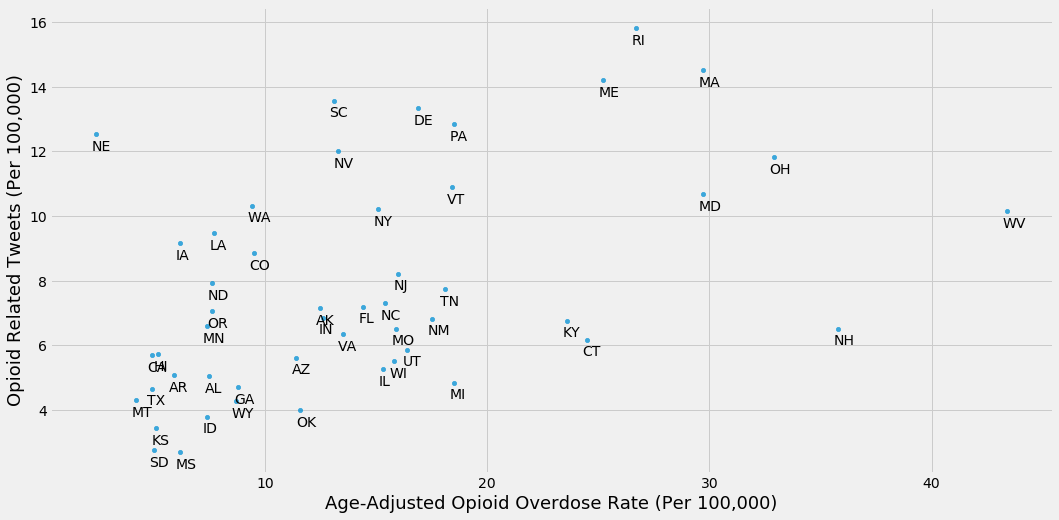

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

x = od_tweets_by_state.adjusted_rate_total.astype(float)
y = od_tweets_by_state.total_tweets_per_100k

plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(16, 8))
ax.scatter(x,y, s=20, alpha=0.75)
for i, txt in enumerate(od_tweets_by_state['state_abbrev']):
    ax.annotate(txt, ((x[i]-0.2),(y[i]-0.5)))
    
ax.set_xlabel('Age-Adjusted Opioid Overdose Rate (Per 100,000)', fontsize=18)
ax.set_ylabel('Opioid Related Tweets (Per 100,000)', fontsize=18)